In [1]:
# this hack is needed for relative operations
# see: https://stackoverflow.com/questions/16981921/relative-imports-in-python-3/16985066
import repackage; repackage.up()
from src.lib.db_operations import vdw_connect
import pandas as pds
import matplotlib.pyplot as plt
import seaborn as sns

connection = vdw_connect() # connect to database
df_demographics = pds.read_sql("select * from demographics", connection) # load demographics data

connection.close() # close db connection

In [2]:
# df_demographics.head()

In [3]:
# find out the number each sex type
sex_count = df_demographics.groupby('SEX').size()
sex_count.head()

SEX
F    7343
M    5777
dtype: int64

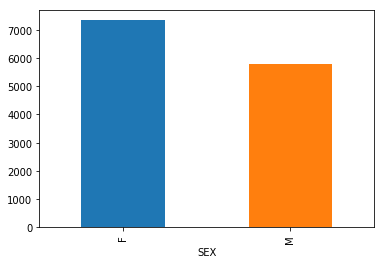

In [4]:
sex_count.plot.bar() # visualize with simple bar plot

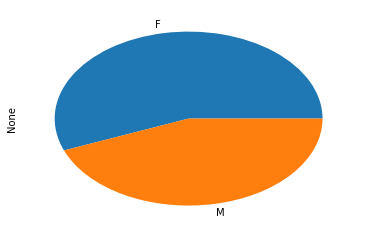

In [5]:
sex_count.plot.pie() # simple pie chart

In [6]:
# add an age column (as of 2018-10-07)
from datetime import date

df_demographics["age"] = date.today().year - df_demographics.BIRTH_YEAR.map(lambda x: int(x))
# df_demographics.head()

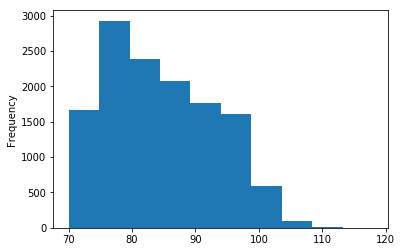

In [7]:
# show distribution of age
df_demographics["age"].plot(kind='hist')

In [338]:
# lets looks at tooth restorations
sql = """
SELECT STUDY_ID, ADATE, ADA_CODE, TOOTH, SURFACE_B, SURFACE_D, SURFACE_I, SURFACE_L, SURFACE_M, SURFACE_O
FROM VDW.`dental-procedure-diagnosis`
WHERE ADA_CODE LIKE 'D%'
AND TOOTH > 0
AND (SURFACE_B > 0
	 OR SURFACE_D > 0
     OR SURFACE_I > 0
     OR SURFACE_L > 0
     OR SURFACE_M > 0
     OR SURFACE_O > 0)
"""

# create dataframe with restoration info
connection = vdw_connect()
df_restorations = pds.read_sql(sql, connection)
connection.close()

# df_restorations.head()

In [339]:
tooth_counts = df_restorations.groupby('TOOTH').size()
tooth_counts.head()

TOOTH
1     338
2    2598
3    3073
4    2011
5    2079
dtype: int64

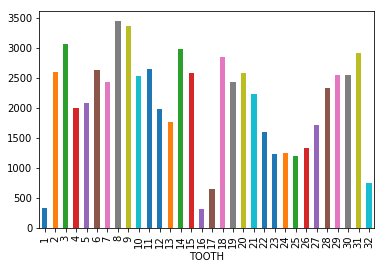

In [311]:
tooth_counts.plot.bar()

In [367]:
# create dataframe of only suface info
df_surfaces = df_restorations[['SURFACE_B', 'SURFACE_D', 'SURFACE_I', 'SURFACE_L', 'SURFACE_M', 'SURFACE_O']]
df_surfaces.head()

,SURFACE_B,SURFACE_D,SURFACE_I,SURFACE_L,SURFACE_M,SURFACE_O
0,0,1,0,1,0,1
1,1,0,0,0,1,1
2,0,1,0,0,0,1
3,1,0,0,0,0,0
4,0,0,1,1,1,0


In [361]:
# calc number of surfaces restored for each surface
surface_counts = df_surfaces.apply(sum)
surface_counts.head()

SURFACE_B    25487
SURFACE_D    27216
SURFACE_I     7803
SURFACE_L    20076
SURFACE_M    23158
dtype: int64

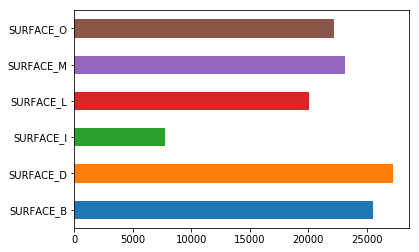

In [362]:
surface_counts.plot.barh()

In [387]:
gs = df_surfaces.groupby(['SURFACE_B', 'SURFACE_D', 'SURFACE_I', 'SURFACE_L', 'SURFACE_M', 'SURFACE_O'])
s = df_surfaces.apply(sum).reset_index()
# s
# gs.agg(sum)
s

,index,0
0,SURFACE_B,25487
1,SURFACE_D,27216
2,SURFACE_I,7803
3,SURFACE_L,20076
4,SURFACE_M,23158
5,SURFACE_O,22181


In [365]:
# build dataframe of tooth and surface info
df_tooth_surfaces = df_restorations[['TOOTH', 'SURFACE_B', 'SURFACE_D', 'SURFACE_I', 'SURFACE_L', 'SURFACE_M', 'SURFACE_O']]
df_tooth_surfaces.head()

,TOOTH,SURFACE_B,SURFACE_D,SURFACE_I,SURFACE_L,SURFACE_M,SURFACE_O
0,30,0,1,0,1,0,1
1,32,1,0,0,0,1,1
2,3,0,1,0,0,0,1
3,19,1,0,0,0,0,0
4,8,0,0,1,1,1,0


In [366]:
# for each tooth group, sum the surfaces restored
grouped = df_tooth_surfaces.groupby('TOOTH').sum()
grouped.head()

,SURFACE_B,SURFACE_D,SURFACE_I,SURFACE_L,SURFACE_M,SURFACE_O
TOOTH,,,,,,
1,113,55,0,38,211,225
2,728,681,0,730,1306,1557
3,644,1225,0,1132,1134,1681
4,521,1139,0,441,846,1127
5,682,1148,0,355,721,1188


In [302]:
# sns.heatmap(grouped, cmap='RdYlGn_r', linewidths=0.5, annot=True)
df = pds.DataFrame(grouped).reset_index()
df.columns = ['tooth', 'surface', 'total']
df.set_index('tooth', inplace=True)

# df.query("""tooth == 8""")
df
# df.unstack()
# sns.heatmap(df, cmap='RdYlGn_r', linewidths=0.5, annot=True)

ValueError: Length mismatch: Expected axis has 8 elements, new values have 3 elements